In [4]:
import os

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [6]:
store_sales = pd.read_csv("/content/dataset.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Used to check null values in dataset

In [7]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839940 entries, 0 to 839939
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    839940 non-null  object
 1   store   839940 non-null  int64 
 2   item    839940 non-null  int64 
 3   sales   839940 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 25.6+ MB


Used for dropping store and item columns used to cleanse data

In [8]:
store_sales = store_sales.drop(['store','item'],axis=1)

In [9]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839940 entries, 0 to 839939
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    839940 non-null  object
 1   sales   839940 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.8+ MB


Converting date from object datatype to datetime datatype

In [10]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [11]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839940 entries, 0 to 839939
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    839940 non-null  datetime64[ns]
 1   sales   839940 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.8 MB


Converting date to a month period,sum of no.of items in each month

In [12]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

Converting the resultant date column to timestamp datatype

In [13]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

Displaying top 10 values

In [14]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,425675
1,2013-02-01,429929
2,2013-03-01,577278
3,2013-04-01,637864
4,2013-05-01,714540
5,2013-06-01,744063
6,2013-07-01,800929
7,2013-08-01,717608
8,2013-09-01,645425
9,2013-10-01,614178


plotting graph of date vs sales by keeping sales on y -axis and date on x-axisas a title monthly customer sales and with inches 15 as a width and 5 as a height

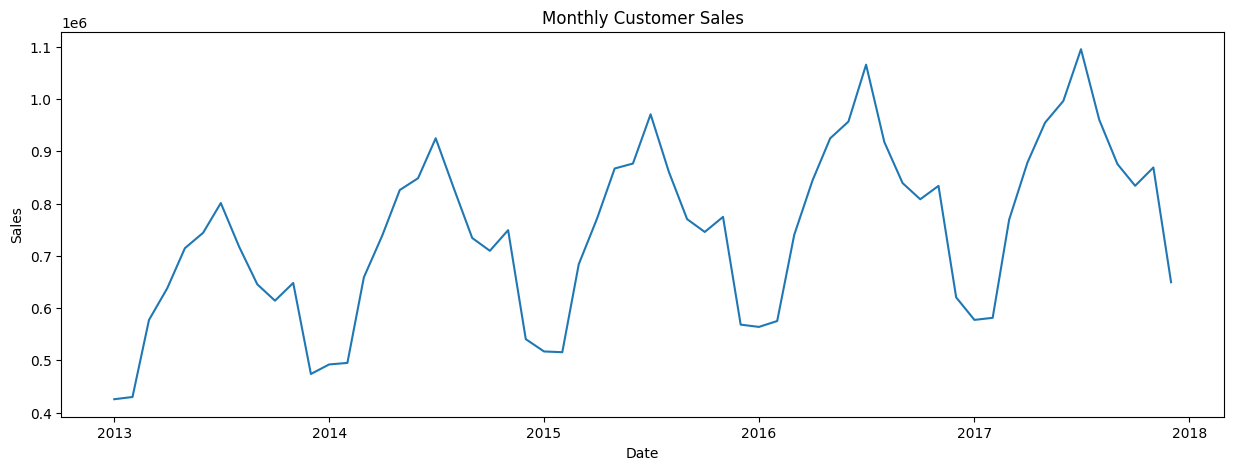

In [15]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

Find the difference of sales between months on sales column to make sales data stationery

In [16]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,429929,4254.0
2,2013-03-01,577278,147349.0
3,2013-04-01,637864,60586.0
4,2013-05-01,714540,76676.0
5,2013-06-01,744063,29523.0
6,2013-07-01,800929,56866.0
7,2013-08-01,717608,-83321.0
8,2013-09-01,645425,-72183.0
9,2013-10-01,614178,-31247.0
10,2013-11-01,648080,33902.0


Plotting the difference of sales monthlywise


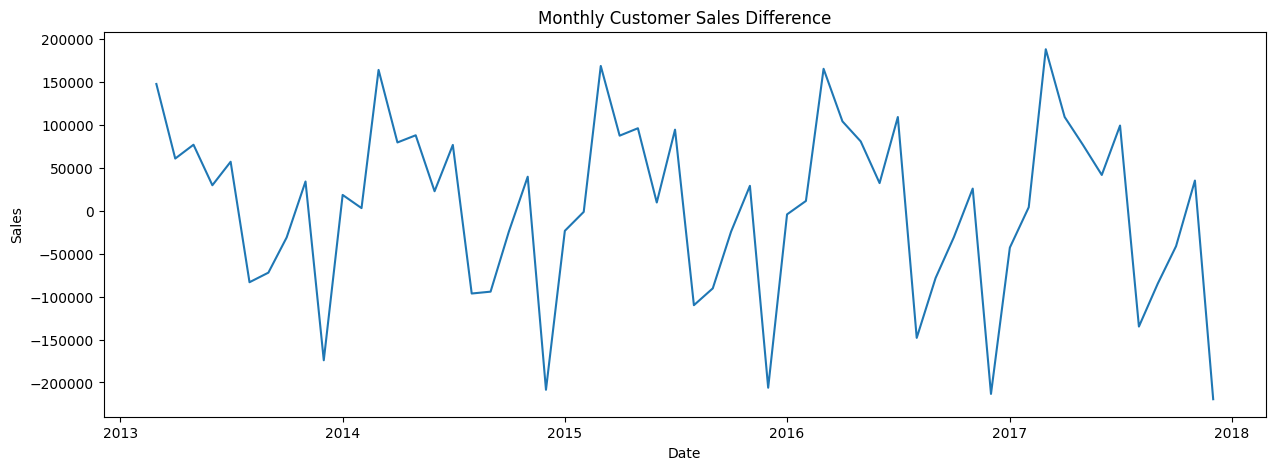

In [17]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'].diff())
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

Dropping off sales and date used 4 prediction

In [18]:
supervised_data = monthly_sales.drop(['date','sales'],axis=1)

Making arrangements to get supervised data or else modified data




Which data is called as supervised data?
Supervised learning is a machine learning approach that's defined by its use of labeled datasets. These datasets are designed to train or “supervise” algorithms into classifying data or predicting outcomes accurately.

In [19]:
for i in range(1,13):
  col_name = 'month_'+str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0,56866.0,29523.0,76676.0,60586.0,147349.0,4254.0
1,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0,56866.0,29523.0,76676.0,60586.0,147349.0
2,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0,56866.0,29523.0,76676.0,60586.0
3,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0,56866.0,29523.0,76676.0
4,22548.0,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0,56866.0,29523.0
5,76449.0,22548.0,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0,56866.0
6,-96463.0,76449.0,22548.0,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0,-83321.0
7,-94296.0,-96463.0,76449.0,22548.0,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0,-72183.0
8,-24496.0,-94296.0,-96463.0,76449.0,22548.0,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0,-31247.0
9,39464.0,-24496.0,-94296.0,-96463.0,76449.0,22548.0,87668.0,79314.0,163749.0,2928.0,18248.0,-174146.0,33902.0


Going to divide data to train and test

Splitting data into train/test.



train_data = supervised_data[:-12] test_data = supervised_data[-12:]

print("Train Data Shape: ", train_data.shape)

print("Test Data Shape: ", test_data.shape)

This code snippet is dividing a dataset into two parts: a training set and a test set.

The first line of code creates the training set by slicing the supervised_data array from the beginning up to the 12th last element (exclusive). This means that the training set contains all but the last 12 elements of supervised_data.

The second line of code creates the test set by slicing the supervised_data array from the 12th last element to the end. This means that the test set contains the last 12 elements of supervised_data.

The shape attribute returns the dimensions of the array. The train_data.shape and test_data.shape lines print out the dimensions of the training and test sets, respectively.

It's worth noting that this code assumes that the supervised_data array is a NumPy array or a similar data structure that supports slicing and has a shape attribute.

In [20]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [21]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [22]:
X_train, y_train =train_data[:,1:], train_data[:,0:1]
X_test,y_test = test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (35, 12)
y_train shape:  (35,)
X_test shape:  (12, 12)
y_test shape:  (12,)


In [23]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)


In [24]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[620483, 577433, 581358, 769163, 878116, 954669, 996159, 1095150, 960240, 875343, 833948, 868950, 649486]


In [25]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [26]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre, X_test],axis =1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [27]:
result_list =[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="LinearPrediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True,right_index= True)


In [28]:
print(predict_df)

         date  LinearPrediction
0  2017-01-01      6.064968e+05
1  2017-02-01      5.873720e+05
2  2017-03-01      7.676155e+05
3  2017-04-01      8.821925e+05
4  2017-05-01      9.658969e+05
5  2017-06-01      9.970879e+05
6  2017-07-01      1.124501e+06
7  2017-08-01      9.356004e+05
8  2017-09-01      8.819275e+05
9  2017-10-01      8.499635e+05
10 2017-11-01      8.573991e+05
11 2017-12-01      6.499497e+05


In [29]:
lr_mse = np.sqrt(mean_squared_error(predict_df['LinearPrediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['LinearPrediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score = (predict_df['LinearPrediction'],monthly_sales['sales'][-12:])
print("Linear Regression MSE: ",lr_mse )
print("Linear Regression MAE: ",lr_mae)
print("Linear Regression R2: ",lr_r2)

Linear Regression MSE:  15622.940530386786
Linear Regression MAE:  11788.670526796495
Linear Regression R2:  (0     6.064968e+05
1     5.873720e+05
2     7.676155e+05
3     8.821925e+05
4     9.658969e+05
5     9.970879e+05
6     1.124501e+06
7     9.356004e+05
8     8.819275e+05
9     8.499635e+05
10    8.573991e+05
11    6.499497e+05
Name: LinearPrediction, dtype: float64, 48     577433
49     581358
50     769163
51     878116
52     954669
53     996159
54    1095150
55     960240
56     875343
57     833948
58     868950
59     649486
Name: sales, dtype: int64)


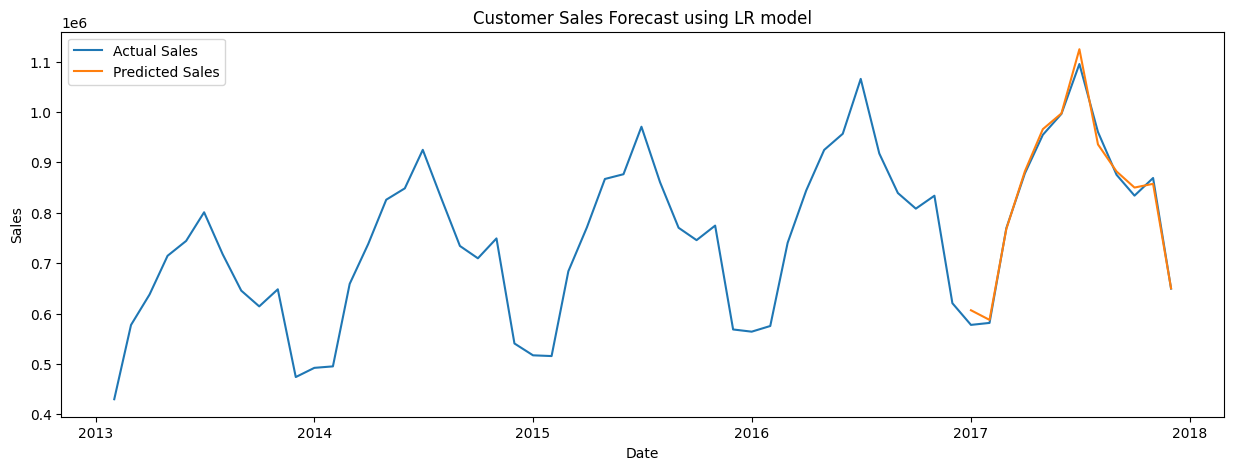

In [30]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['LinearPrediction'])
plt.title("Customer Sales Forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Actual Sales","Predicted Sales"], loc = 'upper left')
plt.show()